In [1]:
#import libraries
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
%matplotlib inline

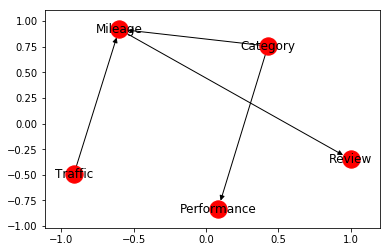

In [2]:
#Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianModel([('Traffic', 'Mileage'), ('Category', 'Mileage'), ('Mileage', 'Review'), ('Category', 'Performance')])
nx.draw_networkx(model)

#### Now let us create the Conditional probability distributions for each of the variables introduced 

In [3]:
cpd_t = TabularCPD(variable='Traffic', variable_card=2, values=[[0.6, 0.4]])
cpd_c = TabularCPD(variable='Category', variable_card=2, values=[[0.7, 0.3]])

In [4]:
cpd_m = TabularCPD(variable='Mileage', variable_card=3, 
                   values=[[0.2, 0.05, 0.9,  0.3],
                           [0.6, 0.25, 0.08, 0.5],
                           [0.2, 0.7,  0.02, 0.2]],
                  evidence=['Category', 'Traffic'],
                  evidence_card=[2, 2])

In [5]:
cpd_r = TabularCPD(variable='Review', variable_card=2, 
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['Mileage'],
                   evidence_card=[3])

In [6]:
cpd_p = TabularCPD(variable='Performance', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['Category'],
                   evidence_card=[2])

In [7]:
model.add_cpds(cpd_t, cpd_c, cpd_m, cpd_r, cpd_p)

In [8]:
print(model.get_cpds('Mileage'))

+-----------+------------+------------+------------+------------+
| Category  | Category_0 | Category_0 | Category_1 | Category_1 |
+-----------+------------+------------+------------+------------+
| Traffic   | Traffic_0  | Traffic_1  | Traffic_0  | Traffic_1  |
+-----------+------------+------------+------------+------------+
| Mileage_0 | 0.2        | 0.05       | 0.9        | 0.3        |
+-----------+------------+------------+------------+------------+
| Mileage_1 | 0.6        | 0.25       | 0.08       | 0.5        |
+-----------+------------+------------+------------+------------+
| Mileage_2 | 0.2        | 0.7        | 0.02       | 0.2        |
+-----------+------------+------------+------------+------------+


### Inference using Gibbs Sampler

#### Having constructed a model, now the process of inference is making queries about the variables in the model. We use Gibbs sampler to sample from the model.



In [9]:
from pgmpy.sampling import GibbsSampling
infer = GibbsSampling(model)

#### Lets now get few samples from our model.This method returns 'size' number of samples from the model

In [10]:
samples =infer.generate_sample(size=10)

In [11]:
for sample in samples:
    print(sample)

[State(var='Traffic', state=0), State(var='Mileage', state=1), State(var='Category', state=0), State(var='Review', state=1), State(var='Performance', state=0)]
[State(var='Traffic', state=0), State(var='Mileage', state=1), State(var='Category', state=0), State(var='Review', state=1), State(var='Performance', state=0)]
[State(var='Traffic', state=0), State(var='Mileage', state=1), State(var='Category', state=0), State(var='Review', state=0), State(var='Performance', state=0)]
[State(var='Traffic', state=0), State(var='Mileage', state=2), State(var='Category', state=0), State(var='Review', state=0), State(var='Performance', state=1)]
[State(var='Traffic', state=1), State(var='Mileage', state=2), State(var='Category', state=1), State(var='Review', state=0), State(var='Performance', state=1)]
[State(var='Traffic', state=1), State(var='Mileage', state=1), State(var='Category', state=1), State(var='Review', state=1), State(var='Performance', state=1)]
[State(var='Traffic', state=0), State(va

#### But to make marginal probability queries or MAP queries, we must derive the statistics from these samples. There is another method which can return a dataframe that will ease the process of computing probabilities

In [12]:
samples_df = infer.sample(size=100,return_type='dataframe')
samples_df.head()

,Traffic,Mileage,Category,Review,Performance
0,0,0,1,1,1
1,0,0,1,1,1
2,1,1,1,0,1
3,1,2,0,0,0
4,1,1,0,1,1


In [13]:
t_df=samples_df.groupby('Traffic').size()
t_df

Traffic
0    54
1    46
dtype: int64

In [14]:
P_0= t_df[0]/len(samples_df)
P_1 = t_df[1]/len(samples_df)

print("Probability of T0:",P_0)
print("Probability of T1:",P_1)

Probability of T0: 0.54
Probability of T1: 0.46


In [15]:
m_df=samples_df.groupby('Mileage').size()
m_df

Mileage
0    36
1    27
2    37
dtype: int64

In [16]:
P_M0= m_df[0]/len(samples_df)
P_M1 = m_df[1]/len(samples_df)
P_M2 = m_df[2]/len(samples_df)

print("Probability of M0:",P_M0)
print("Probability of M1:",P_M1)
print("Probability of M2:",P_M2)

Probability of M0: 0.36
Probability of M1: 0.27
Probability of M2: 0.37


#### You can compare these with the results obtained through exact inference in previous notebook and might observe that the marginal probability values are bit off. For sampling based methods, we need larger number of samples to ensure that the sampler reaches its stationary values.Lets increase the number of samples and recompute the values

In [17]:
samples_df = infer.sample(size=100000,return_type='dataframe')
samples_df.head()

,Traffic,Mileage,Category,Review,Performance
0,0,1,0,1,0
1,0,1,0,1,0
2,0,1,0,1,1
3,0,1,1,0,1
4,1,1,1,0,1


In [18]:
m_df=samples_df.groupby('Mileage').size()
m_df

Mileage
0    29712
1    39250
2    31038
dtype: int64

In [19]:
P_M0= m_df[0]/len(samples_df)
P_M1 = m_df[1]/len(samples_df)
P_M2 = m_df[2]/len(samples_df)

print("Probability of M0:",P_M0)
print("Probability of M1:",P_M1)
print("Probability of M2:",P_M2)

Probability of M0: 0.29712
Probability of M1: 0.3925
Probability of M2: 0.31038


### Conditional queries

#### We can also fix values for some variables and then query the model for another variable of interest. Let us fix the traffic to be low(T_O) and the car to be a sports car(C_1)

In [20]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State

In [21]:
inference = BayesianModelSampling(model)

In [22]:
#Fixing the state of traffic and car category
evidence =[State('Traffic', 0), State('Category',1)]

In [23]:
query_df=inference.likelihood_weighted_sample(evidence=evidence, size=10000, return_type='dataframe')

In [24]:
query_df.head()

,Category,Performance,Traffic,Mileage,Review,_weight
0,1,0,0,0,1,0.18
1,1,0,0,0,1,0.18
2,1,1,0,0,1,0.18
3,1,0,0,0,1,0.18
4,1,1,0,0,1,0.18


In [25]:
m_df= query_df.groupby('Mileage').size()
m_df

Mileage
0    8997
1     801
2     202
dtype: int64

In [26]:
P_M0= m_df[0]/len(query_df)
P_M1 = m_df[1]/len(query_df)
P_M2 = m_df[2]/len(query_df)

print("Probability of M0:",P_M0)
print("Probability of M1:",P_M1)
print("Probability of M2:",P_M2)

Probability of M0: 0.8997
Probability of M1: 0.0801
Probability of M2: 0.0202


#### The values obtained here must be closer to the ones obtained in exact inference, if not increase the number of samples.

